In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import os
import glob
import pickle
from operator import itemgetter
from Bio import SeqIO
import csv
import scipy
from scipy import stats
import pybedtools
from matplotlib_venn import venn3, venn3_circles,venn3_unweighted,venn2
import seaborn as sns
from pandas import DataFrame


# Initialization

In [11]:
tools=["IDP-fusion","FusionCatcher"]
sample="MCF7"

gencode_gtf="/path/to/gencode.v19.annotation.gtf"
gold_set="/path/to/idp_gold_set.txt"

# Prediction

In [4]:
pred_file={}


pred_file["FusionCatcher"]="/path/to/final-list_candidate-fusion-genes.txt"
pred_file["IDP-fusion"]="/path/to/preds.txt"

# Functions

In [5]:
def parse_fusion(predfile,tool):
    preds=[]
    
    if tool=="FusionCatcher":
        with open(predfile,"r") as csv_file:
            spamreader = csv.reader(csv_file, delimiter='\t', quotechar='|')
            cnt=0
            for row in spamreader:
                if cnt==0:
                    cnt+=1
                    continue
                if cnt==1:
                    preds.append([row[0],row[1],row[8].split(":")[0],
                                  row[8].split(":")[1],row[9].split(":")[0],row[9].split(":")[1]])
    elif tool=="IDP-fusion":
        with open(predfile,"r") as csv_file:
            spamreader = csv.reader(csv_file, delimiter='\t', quotechar='|')
            cnt=0
            for row in spamreader:
                if cnt==0:
                    cnt+=1
                    continue
                if cnt==1:
                    if not row[0]:
                        continue
                    preds.append([row[0].split("-")[0],row[0].split("-")[1],
                                  row[9].split("chr")[1],
                                  row[10],
                                  row[13].split("chr")[1],
                                  row[14]
                                 ])
    else:
        print "NO file ", tool
        
    
    Fs=set([])
    nonredundant_preds=[]
    for pred in preds:
        g1,g2=pred[0:2]
        fs="%s:%s"%(g1,g2)
        if fs not in Fs:
            nonredundant_preds.append(pred)
            Fs.add(fs)
        
    return nonredundant_preds



In [6]:
def parse_gold(goldfile):
    gs=[]
    with open(goldfile,"r") as csv_file:
        spamreader = csv.reader(csv_file, delimiter='\t', quotechar='|')
        for row in spamreader:
            gs.append(row)

    genes=set([x for w in gs for x in w])
    coord={}
    for gene in genes:
        if gene[0:3]=="chr":
            c=gene.split(":")[0][3:]
            p1=gene.split(":")[1].split("-")[0]
            p2=gene.split(":")[1].split("-")[1] if "-" in gene else str(int(p1)+1)
            coord[gene]=[c,p1,p2]
            
    with open(gencode_gtf,"r") as csv_file:
        spamreader = csv.reader(csv_file, delimiter='\t', quotechar='|')
        for row in spamreader:
            if row[0][0]=="#":
                continue
            if row[2]=="gene":
                gene_info = {k.split()[0]:k.split()[1][1:-1] for k in ' '.join(row[8:]).split(";")[:-1]}
                name=gene_info["gene_name"]
                if name in genes:
                    if name in coord:
                        print "DUP",name
                    coord[name]=[row[0],row[3],row[4]]
                    
    gs=map(lambda x:x+coord[x[0]]+coord[x[1]],gs)
    return gs,coord

gs,coord=parse_gold(gold_set)
genes_gs=set([x for w in gs for x in w[0:2]])
gs_dict={}
for g in gs:
    if g[0] not in gs_dict:
        gs_dict[g[0]]={}
    if g[1] not in gs_dict[g[0]]:
        gs_dict[g[0]][g[1]]=[]
    gs_dict[g[0]][g[1]].append(g[2:])
    if g[1] not in gs_dict:
        gs_dict[g[1]]={}
    if g[0] not in gs_dict[g[1]]:
        gs_dict[g[1]][g[0]]=[]
    gs_dict[g[0]][g[1]].append(g[2:])
    
intervals=[]
processed_gs=set([])
for g in gs:
    if g[0] not in processed_gs:
        intervals.append(pybedtools.Interval(chrom=g[2],start=int(g[3]),end=int(g[4]),name=g[0]))
        processed_gs.add(g[0])
    if g[1] not in processed_gs:
        intervals.append(pybedtools.Interval(chrom=g[5],start=int(g[6]),end=int(g[7]),name=g[1]))
        processed_gs.add(g[1])

gs_bed=pybedtools.BedTool(intervals).sort()       



In [7]:
def evaluate(pred):
    tp=0
    fp=0
    for fusion in pred:
        g1,g2,c1,p1,c2,p2=fusion
        if g1 not in genes_gs:
            my_bed1=pybedtools.BedTool([pybedtools.Interval(chrom=c1,start=int(p1),end=int(p1)+1,name=g1)])
            matches1=my_bed1.window(gs_bed,w=0)
            if len(matches1)>1:
                aaaa
            elif len(matches1)==1:
                g1=matches1[0][9]
            else:
                fp+=1
                continue

        if g2 not in genes_gs:
            my_bed2=pybedtools.BedTool([pybedtools.Interval(chrom=c2,start=int(p2),end=int(p2)+1,name=g2)])
            matches2=my_bed2.window(gs_bed,w=0)
            if len(matches2)>1:
                aaaa
            elif len(matches2)==1:
                g2=matches2[0][9]
            else:
                fp+=1
                continue
        
        
        if g2 in gs_dict[g1]:
            tp+=1
        else:
            fp+=1

    print fp,tp,len(pred)-fp-tp
    return fp,tp

In [8]:
preds={}
for tool in tools:
    pred=parse_fusion(pred_file[tool],tool)
    preds[tool]=pred

In [9]:
performance={}
for tool in tools:
    fp,tp=evaluate(preds[tool]) 
    performance[tool]={"FP":fp,"TP":tp,"PR":tp/float(tp+fp+0.0001),"SN":tp/float(len(gs))}
    print tool,performance[tool]


16 19 0
IDP-fusion {'FP': 16, 'PR': 0.5428555918411662, 'SN': 0.2676056338028169, 'TP': 19}
51 27 0
FusionCatcher {'FP': 51, 'PR': 0.34615340236743286, 'SN': 0.38028169014084506, 'TP': 27}


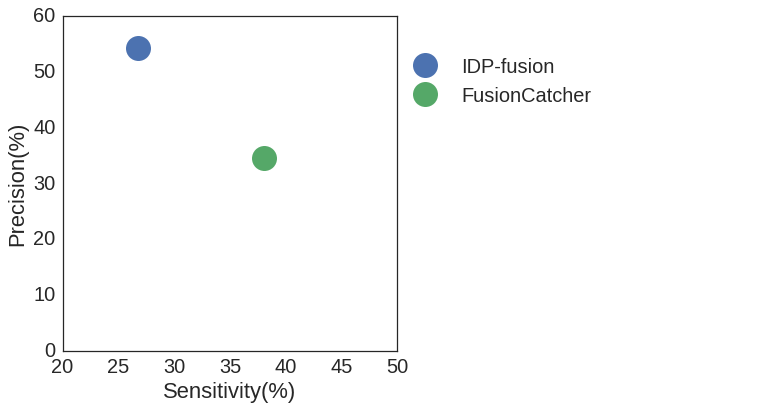

In [10]:
sns.set(style="white",font_scale=2) 
fig, ax = plt.subplots(figsize=(6,6))
x=[]
y=[]
for tool in tools:
    x=(performance[tool]["SN"]*100)
    y=(performance[tool]["PR"]*100)
    label=tool
    ax.plot(x,y,label=label,linestyle=""
               ,marker="o",markersize=25)
ax.set_yticks(range(0,70,10))
ax.set_ylim([0,60])
ax.set_xticks(range(20,55,5))
ax.set_xlim([20,50])
ax.set_xlabel("Sensitivity(%)")
ax.set_ylabel("Precision(%)")

ax.legend(bbox_to_anchor=(1, 0.8, 1.1, 0.1), loc=1,ncol=1,
          mode="expand", borderaxespad=0.,frameon=False)
